<a href="https://colab.research.google.com/github/erickbonas/projetofinal/blob/main/tfidf_n_gramas_smoteen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baixando Arquivos

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"erickbonifaciobello","key":"83ea173a21a1480a84351e3b1e475891"}'}

In [2]:
! pip install kaggle==1.5.6
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

     |████████████████████████████████| 61kB 4.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp37-none-any.whl size=72858 sha256=5ddaea16c84e874b7402f7370c6ff55a67c87425a6729e59e7c8177d74cfbd3b
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [3]:
! mkdir dataset

In [4]:
! kaggle competitions download -c fake-news-pair-classification-challenge -p '/content/dataset'

 26% 9.00M/34.6M [00:00<00:00, 33.1MB/s]
100% 34.6M/34.6M [00:00<00:00, 93.6MB/s]


In [5]:
! unzip '/content/dataset/fake-news-pair-classification-challenge.zip' -d '/content/dataset'

Archive:  /content/dataset/fake-news-pair-classification-challenge.zip
  inflating: /content/dataset/sample_submission.csv  
  inflating: /content/dataset/test.csv  
  inflating: /content/dataset/train.csv  


## Tratamento de dados

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTEENN
np.random.seed(1082141) 

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [57]:
training = pd.read_csv('dataset/train.csv')
training = training.sample(n=20000)

In [58]:
#Aplica strip em todas as colunas do dataframe
training = training.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [59]:
training = training.replace(r'^\s*$', np.nan, regex=True)

In [60]:
# Remove todos os NaN da tabela
training = training.dropna()

# Classificadores

Sugestão colocar uma semente

In [61]:
df_train, df_val = train_test_split(training[['title1_en', 'title2_en', 'label']], test_size=0.2, shuffle=True)
df_train

,title1_en,title2_en,label
306605,The succulent and succulent steak is glued to ...,"This kind of ""glue"" has been on the market all...",agreed
295465,Liang Hua will replace Huawei as chairman of H...,I quit my job? No! I didn't do my best!,unrelated
126392,Feed the baby tadpole?! I'm sweaty...,"Mother hears that the child eats ""live tadpole...",agreed
281735,"Graphite number one has been awakened, net pro...","Zhang Liangying has been transfected, 51 -year...",unrelated
122639,"Tell people the cell phone charge is less, the...","Double shadow, film die, Sun Yanyi crash, Shu ...",unrelated
...,...,...,...
155388,Sun Yat-sen Silver Dollars - some rare edition...,"""Running Man"" is exposed: First, no suspense, ...",unrelated
141597,"God is banned, Zhao Benshan daughter ball, be ...",God and zhao benshan daughter qiu qiaoqiu brok...,unrelated
43646,A mosquito-repellent incense over six packs of...,Disinformation: 1 dish of mosquito-repellent i...,unrelated
318852,"Tea ""strange"" eating, it is a hypoglycemic dev...",Do not blindly take the medicine to reduce blo...,unrelated


In [64]:
x_train, x_val = df_train[['title1_en', 'title2_en']], df_val[['title1_en', 'title2_en']]
y_train, y_val = df_train['label'], df_val['label']
x_val

,title1_en,title2_en
40776,One week E car reviews the Yangtze River won p...,"new energy cars collided with a streetcar, the..."
189200,Ski5Virus Death Attacks in Yunnan Province's H...,"A man in liuzhou, guangxi, spread a rumor that..."
285822,"An empty stomach can not eat 12 things, hungry...","""Special Topics"" often eat garlic can prevent ..."
88461,"Rural pensions less than city? Don't worry, st...",The urban and rural endowment is not equal? Th...
132985,"The local state reappearance ""new dragon head""...","Mixed to the first dragon head, by the main bo..."
...,...,...
293313,"after lindan liu kai - wei, wu jing, a martial...",Lin Dan has an affair with Wu Jing too? The wi...
201845,Teach you 5 ways to improve diabetic hyperglyc...,Good news for people with hyperglycemia. Keep ...
251266,Will it fail if it does not change the current...,Is the drip-drip-dripping car in Canton closed...
70795,The chairman of the board of directors is stil...,China PingAn clarify the chairman change rumor...


In [66]:
features = 200

encoder = make_pipeline(TfidfVectorizer(min_df=5,
                                        stop_words='english',
                                        strip_accents='unicode',                                        
                                        ngram_range=(1,3),
                                        max_features=features),                                        
                        StandardScaler(with_mean=False))

x_train_title1 = encoder.fit_transform(x_train['title1_en']).toarray()
x_val_title1 = encoder.transform(x_val['title1_en']).toarray()

x_train_title2 = encoder.fit_transform(x_train['title2_en']).toarray()
x_val_title2 = encoder.transform(x_val['title2_en']).toarray()

In [67]:
label_enc = LabelEncoder()
ye_train = label_enc.fit_transform(y_train)
ye_val = label_enc.transform(y_val)

In [68]:
label_enc.classes_

array(['agreed', 'disagreed', 'unrelated'], dtype=object)

In [69]:
x_train = np.concatenate((x_train_title1, x_train_title2), axis=1)
x_val = np.concatenate((x_val_title1, x_val_title2), axis=1)

In [ ]:
training = None
df_train = None
df_val = None
x_train_title1 = None
x_val_title1 = None
x_train_title2 = None
x_val_title2 = None

In [70]:
x_train.shape

(16000, 400)

In [71]:
y_train.shape

(16000,)

## Regressor logistico

In [76]:
C_range = np.logspace(-3, 2, 5)

lm = LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=200, class_weight='balanced')

grid_values = {'penalty': ['l1','l2'], 'C': C_range}
grid_lm = GridSearchCV(lm, param_grid = grid_values, cv=3, scoring = 'accuracy', n_jobs = -1)

grid_lm.fit(x_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='ovr',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.77827941e-02, 3.16227766e-01, 5.62341325e+00,
       1.00000000e+02]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [77]:
C_best = grid_lm.best_params_['C']
penalty_best = grid_lm.best_params_['penalty']
g = grid_lm 


In [78]:
# Imprimindo os melhores parâmetros encontrados
print("Melhores parametros encontrados %s com score de %0.4f" % (grid_lm.best_params_, grid_lm.best_score_))

Melhores parametros encontrados {'C': 0.001, 'penalty': 'l1'} com score de 0.6807


In [19]:
from sklearn import metrics
import seaborn as sns; sns.set()

def evaluate(y, p, probabilities, labels=None):
    # Cálculo das métricas de acerto.
    print('Accuracy:', metrics.accuracy_score(y, p).round(3))
    print('Accuracy (balanced):', metrics.balanced_accuracy_score(y, p).round(3))
    
    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(y, p)
    r = c / c.sum(axis=1, keepdims=True)
    
    # Impressão dos gráficos.
    (plt
     .figure(figsize=(10, 8))
     .suptitle('Matriz de confusão', fontsize=20))
    sns.heatmap(r,
                cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1%",
                xticklabels=labels, yticklabels=labels, cbar=False)    

Accuracy: 0.668
Accuracy (balanced): 0.37


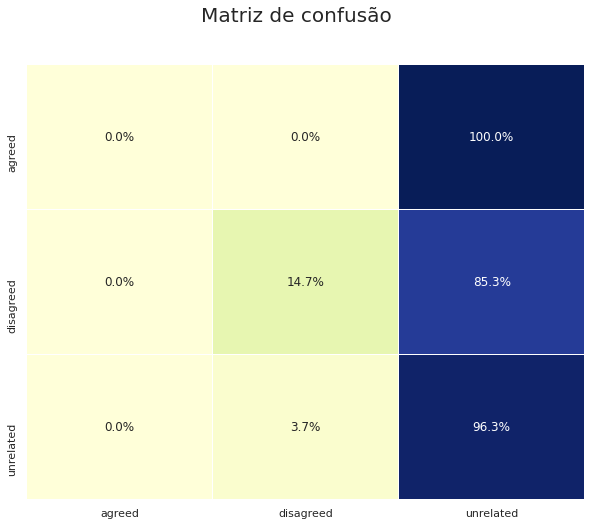

In [79]:
evaluate(y_val, g.predict(x_val), g.predict_proba(x_val), labels=label_enc.classes_)

## FLORESTA ALEATÓRIA

In [36]:
y_train.value_counts()

unrelated    5490
agreed       2309
disagreed     201
Name: label, dtype: int64

In [ ]:
# Random Forest
clf = RandomForestClassifier(   
    random_state=0, 
    oob_score=True, 
    n_jobs=-1, 
    class_weight='balanced', 
    max_features=features
)

grid_clf_values = {'max_depth': [5, 10, 15], 'n_estimators': [100]}
grid_clf = GridSearchCV(clf, param_grid = grid_clf_values, cv=3, scoring = 'balanced_accuracy', n_jobs = -1)

grid_clf.fit(x_train, y_train)

In [ ]:
# Imprimindo os melhores parâmetros encontrados
print("Melhores parametros encontrados %s com score de %0.4f" % (grid_clf.best_params_, grid_clf.best_score_))

Melhores parametros encontrados {'max_depth': 15, 'n_estimators': 200} com score de 0.4199


Accuracy: 0.342
Accuracy (balanced): 0.428


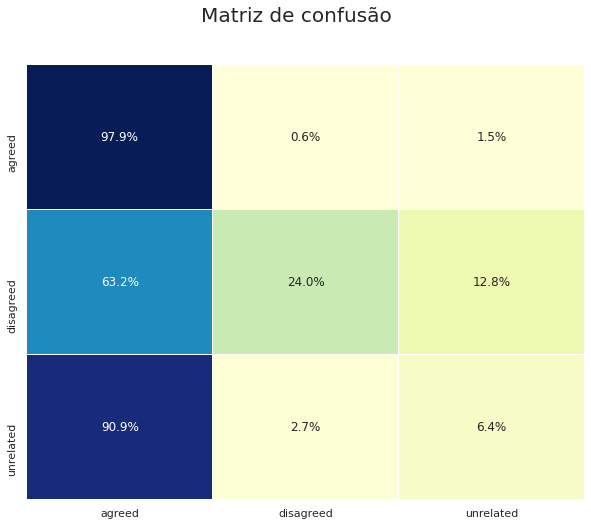

In [ ]:
evaluate(y_val, grid_clf.predict(x_val), grid_clf.predict_proba(x_val), labels=label_enc.classes_)

In [ ]:
# exemplo smote
model = make_pipeline(
  SMOTE(),
  LogisticRegression()
)
model.fit(X, y)
# Exemplo smoteenn
from imblearn.combine import SMOTEENN
resampler = SMOTEENN()
X_resampled, y_resampled = resampler.fit_resample(X, y)

In [72]:
resampler = SMOTEENN(random_state=0)
x_train_resampled, y_train_resampled = resampler.fit_resample(x_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [73]:
y_train_resampled.shape

(20756,)

In [74]:
# Random Forest com SMOTEENN
clf = RandomForestClassifier(   
    random_state=0, 
    oob_score=True, 
    n_jobs=-1, 
    class_weight='balanced', 
    max_features=features
)

grid_clf_values = {'max_depth': [5, 10, 15], 'n_estimators': [50, 150, 200]}
grid_clf = GridSearchCV(clf, param_grid = grid_clf_values, cv=3, scoring = 'balanced_accuracy', n_jobs = -1)

grid_clf.fit(x_train_resampled, y_train_resampled)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=200,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=True, random_state=0,
                                   

Accuracy: 0.413
Accuracy (balanced): 0.547


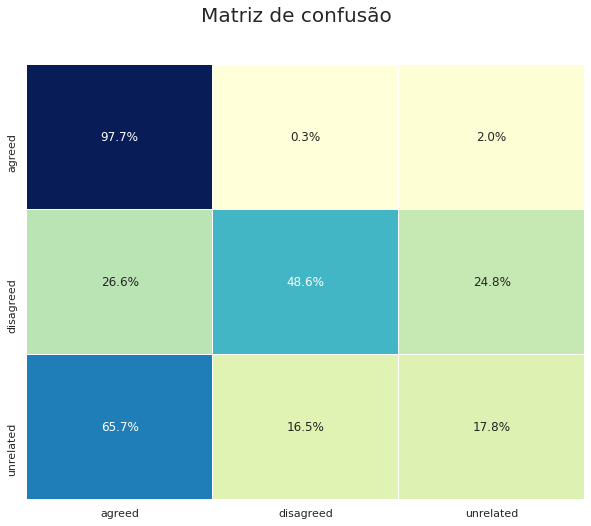

In [75]:
evaluate(y_val, grid_clf.predict(x_val), grid_clf.predict_proba(x_val), labels=label_enc.classes_)

## Redes Neurais

In [ ]:
from keras.utils import np_utils
from keras.models import Sequential
from keras import Model
from keras.layers import Dense, Activation, Input, InputLayer, Dropout
from keras import optimizers, callbacks

In [ ]:
epochs = 20
batch_size = 128
input_shape = [features]

In [ ]:
y_ohe_train = np_utils.to_categorical(ye_train, num_classes=3)
y_ohe_val = np_utils.to_categorical(ye_val, num_classes=3)

In [ ]:
model = Sequential([
InputLayer((1024,)),
Dense(1024, activation="relu"),
Dense(256, activation = "relu"),
Dense(6, activation="softmax")
])

model.compile(optimizer='sgd',
loss='categorical_crossentropy',
# metrics=['accuracy'])
metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])

model.summary()



1.   Fazer tfidf usando os bigramas 
2.   Fazer o SMOTEEN antes de utilizar os classificadores
3.   Rodar novamente os classificadores 
4.   Estudar como usar o hub para classificação de sentimento em textos  https://www.tensorflow.org/tutorials/keras/text_classification_with_hub, https://tfhub.dev/google/universal-sentence-encoder/4
5.   Fazer uma rede normal
6.   Estudar redes siamesas https://keras.io/examples/vision/siamese_contrastive/

Se der tempo 
1. Estudar BERT ( arquitetura moderna para processamento ) 
    https://www.tensorflow.org/text/tutorials/classify_text_with_bert
2. https://huggingface.co/transformers/
3. Aumentação de texto https://arxiv.org/pdf/1901.11196.pdf

5.   Procurar alguma rede pronta como https://tfhub.dev/google/nnlm-en-dim128/2

Uma última dica: tem uma outra formulação para problemas de matching que nós chamamos de metric learning.
O objetivo desse tipo de aprendizado é mapear objetos não-estruturados (ex frases) em um espaço que preserve a relação de contraste entre eles (ex: frases que concordam próximas/frases que discordam distantes).
Nesse tipo de aprendizado, você tem uma rede siamesa (com duas entradas) e uma saída (se as entradas são ou não similares).
Você poderia treinar esse modelo pra identificar se duas frases concordam ou não.
Exemplo no tensorflow: https://keras.io/examples/vision/siamese_contrastive/